# Modelos

En este cuaderno se presenta el entrenamiento de los diferentes modelos predictivos utilizados en el dashboard. En concreto se entrenan modelos para:
- Predicción del número de colegios en funcionamiento. Regresión lineal.
- Predicción de la densidad poblaciónal jóven media. Modelo ARIMA.
- Predicción de la tendencia de matriculados en el sistema universitario en el futuro. Se corresponde con la herramienta del simulador. Modelo lineal generalizado de Poisson.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import pickle
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Modelo predicción colegios

In [41]:
colegios = pd.read_csv("raw/colegios.csv",sep=";")
df = colegios[["curso","colesMMP","colesMP","colesP","colesPP","colesMPP"]]

In [42]:
#Variables a predecir. Entrenamos un modelo por columna. Usamos una regresión lineal tomando los valores de los dos últimos años
columns_to_predict = ["colesMMP", "colesMP", "colesP", "colesPP", "colesMPP"]
models = {}
future_years = list(range(2023, 2029))
predictions_df = pd.DataFrame({"curso": future_years})

for column in columns_to_predict:
    X = []
    y = []
    for i in range(2, len(df)):  
        X.append([df[column].iloc[i - 2], df[column].iloc[i - 1]]) 
        y.append(df[column].iloc[i]) 

    X = pd.DataFrame(X).values  
    y = pd.DataFrame(y).values.flatten()  

    model = LinearRegression()
    model.fit(X, y)
    models[column] = model

    #Generamos las predicciones de los siguientes años
    last_values = list(df[column].iloc[-2:])  
    predictions = []
    for year in future_years:
        next_value = round(model.predict([last_values])[0]) 
        predictions.append(next_value)
        last_values = [last_values[-1], next_value] 

    predictions_df[column] = predictions

#Concatenamos con el dataframe original
df_final = pd.concat([df, predictions_df], ignore_index=True)
df_final.to_csv("smart/colegiosHasta22.csv", index=False)

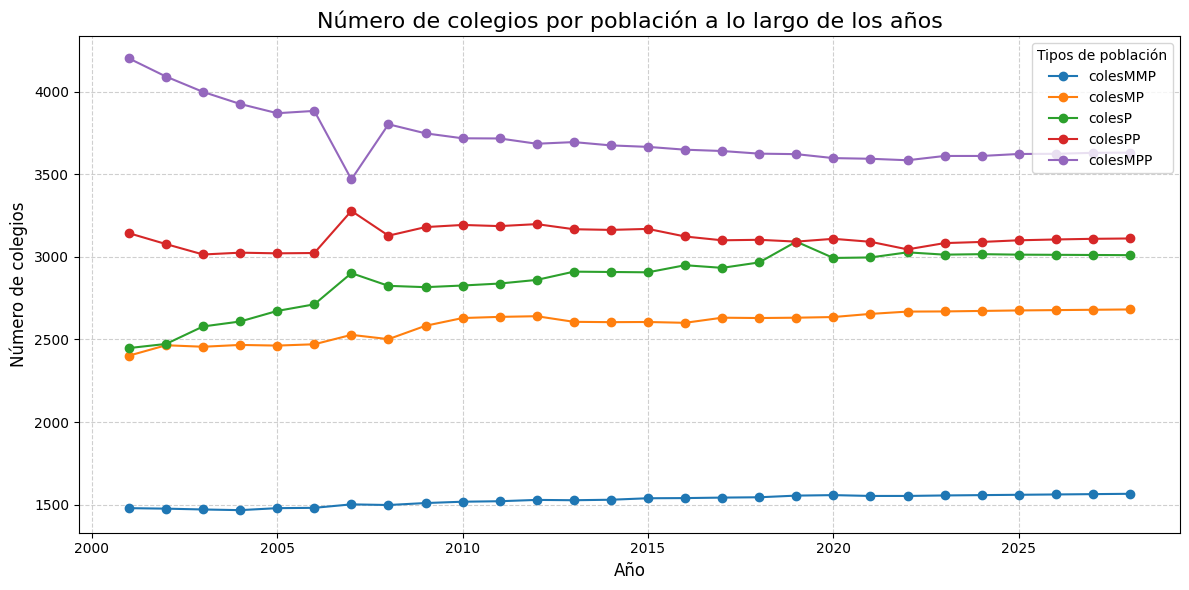

In [43]:
# Graficar los datos
plt.figure(figsize=(12, 6))
for column in columns_to_predict:
    plt.plot(df_final["curso"], df_final[column], label=column, marker="o")

plt.title("Número de colegios por población a lo largo de los años", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de colegios", fontsize=12)
plt.legend(title="Tipos de población", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()

# Modelo predicción densidad poblacional jóven media

In [34]:
ine = pd.read_csv("raw/poblacionRangoEdad.csv")
ine2 = pd.read_csv("raw/INE.csv",sep=";")
ine = ine[ine["Sexo"]=="Total"]
ine = ine[ine["Municipios"]!='Total Nacional']
ine = ine[ine["Edad (grupos quinquenales)"]!='Todas las edades']
ine['periodo'] = ine['Periodo'].str.extract(r'(\d{4})')
ine['periodo'] = ine['periodo'].astype('int')
#Restamos 1 año porque el dato se recoge a día 1 de enero, por lo que representa el valor final del año anterior
ine['periodo'] = ine['periodo']-1
ine['Total'] = ine['Total'].str.replace('.', '', regex=False)
ine = ine.dropna()
ine['Total'] = ine['Total'].astype('int')
ine = ine.rename(columns={'Total': 'Joven'})
ine2 = ine2.dropna()
ine2 = ine2[ine2["Sexo"] == "Total"]
ine2['Total'] = ine2['Total'].str.replace('.', '', regex=False)
ine2 = ine2.dropna()
ine2['Total'] = ine2['Total'].astype('int')
ine2['poblacion'] = ine2['Total'].apply(
    lambda x: 'Muy densa' if x > 500000 else
              'Densa' if x > 100000 else
              'Moderadamente densa' if x > 25000 else
              'Poco densa' if x > 5000 else
              'Muy poco densa'
)
ine2=ine2.drop(columns=['Sexo'])
ine2 = ine2.rename(columns={'Periodo': 'periodo'})
ine2['periodo'] = ine2['periodo'].astype('int')
ine_merged = ine.merge(ine2, on=['Municipios', 'periodo'], how='left')  # Puedes usar 'left' o 'right' si lo necesitas
ine_merged = ine_merged.dropna()
ine = ine_merged.drop(columns=['Periodo','Sexo','Municipios'])
df_grouped = ine.groupby(['poblacion', 'periodo', 'Edad (grupos quinquenales)'], as_index=False).agg({'Joven': 'sum', 'Total': 'sum'})
#Definimos los grupos de edad que queremos conservar
grupos_a_conservar = ["De 0 a 4 años", "De 5 a 9 años", "De 10 a 14 años", "De 15 a 19 años"]
df_filtrado = df_grouped[df_grouped["Edad (grupos quinquenales)"].isin(grupos_a_conservar)]

#Agrupamos por población y periodo, sumando los valores de "Total"
df_resultado = df_filtrado.groupby(["poblacion", "periodo"], as_index=False).agg({'Joven': 'sum', 'Total': 'sum'})
df_resultado['proporcionJoven'] = (df_resultado['Joven'] / df_resultado['Total'])*100
df_resultado = df_resultado.drop(columns=['Joven','Total'])

In [35]:
#Variables a predecir
columns_to_predict = ["Muy poco densa", "Poco densa", "Moderadamente densa", "Densa", "Muy densa"]
future_years = list(range(2022, 2030))

predictions_df = pd.DataFrame({"periodo": future_years})

#Entrenamos un modelo por categoría. En este caso elegimos ARIMA
for column in columns_to_predict:
    df = df_resultado[df_resultado["poblacion"] == column]
    
    if len(df) < 3:
        print(f"No hay suficientes datos para {column}, saltando...")
        predictions_df[column] = [None] * len(future_years)
        continue
        
    series = df.set_index("periodo")["proporcionJoven"]
    model = ARIMA(series, order=(1, 1, 1))
    model_fit = model.fit()

    #Hacemos las predicciones para los años futuros
    predictions = model_fit.forecast(steps=len(future_years))
    predictions_df[column] = predictions.values

In [36]:
#Reestructuramos para tener una fila por año
df_pivot = df_resultado.pivot_table(index='periodo', columns='poblacion', values='proporcionJoven', aggfunc='first')
df_pivot.reset_index(inplace=True)
df_final = pd.concat([df_pivot, predictions_df], ignore_index=True)
df_final = df_final.round(3)
df_final.to_csv("smart/poblacionJoven22.csv", index=False)

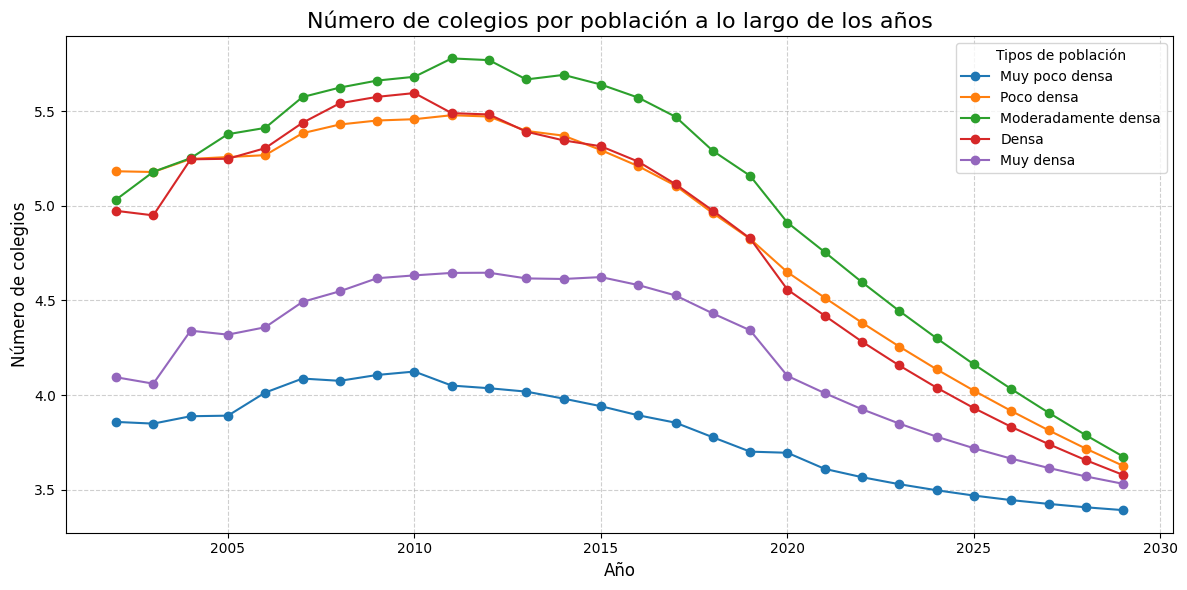

In [37]:
# Graficar los datos
plt.figure(figsize=(12, 6))
for column in columns_to_predict:
    plt.plot(df_final["periodo"], df_final[column], label=column, marker="o")

# Personalización del gráfico
plt.title("Número de colegios por población a lo largo de los años", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de colegios", fontsize=12)
plt.legend(title="Tipos de población", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
#plt.yscale('log')

# Mostrar el gráfico
plt.show()

# Modelos simulador

In [26]:
#Estos dataframe combinan los datasets de los colegios con los de población joven y matrículas (JOIN)
train = pd.read_csv("raw/datosSimulador.csv")
predecir_df = pd.read_csv("raw/prediccionesSimulador.csv")
df = pd.concat([train, predecir_df], ignore_index=True)
#Separamos entre entrenamiento y predicciones a futuro
train = df[df['curso_academico'] <= 2021]
train.to_csv("smart/train_simulador.csv", index=False)
predecir = df[df['curso_academico'] > 2021]
predecir.to_csv("smart/predecir_simulador.csv", index=False)

In [27]:
#Hacemos un modelo por cada universidad. Utilizamos el modelo de Poisson
trainF = train[(train["uva"]==1)&(train["ucm"]==1)&(train["uam"]==1)&(train["uc3m"]==1)&(train["urjc"]==1)]
modelo_poisson = smf.glm(formula='y ~ ' + ' + '.join(trainF.columns.difference(['y'])), data=trainF, family=sm.families.Poisson()).fit()
# Guardar el modelo entrenado en un archivo
with open('smart/modelo_simulador_total.pkl', 'wb') as file:
    pickle.dump(modelo_poisson, file)

df_future = predecir.copy()
df_future = df_future[(df_future["uva"]==1)&(df_future["ucm"]==1)&(df_future["uam"]==1)&(df_future["uc3m"]==1)&(df_future["urjc"]==1)]
#Generar las predicciones a futuro encadenadas
for year in range(2022, 2029):
    df_year = df_future[df_future['curso_academico'] == year].copy()
    df_year['y'] = modelo_poisson.predict(df_year).round().astype(int)
    df_future.loc[df_future['curso_academico'] == year, 'y'] = df_year['y']
    if year < 2028:
        for _, row in df_year.iterrows():
            mask = ((df_future['curso_academico'] == year + 1)&(df_future['Muy_densa'] == row['Muy_densa'])&(df_future['Densa'] == row['Densa'])&(df_future['Moderadamente_densa'] == row['Moderadamente_densa'])&(df_future['Poco_densa'] == row['Poco_densa'])&(df_future['Muy_poco_densa'] == row['Muy_poco_densa'])&(df_future['uva'] == row['uva'])&(df_future['ucm'] == row['ucm'])&(df_future['uam'] == row['uam'])&(df_future['uc3m'] == row['uc3m'])&(df_future['urjc'] == row['urjc']))
            df_future.loc[mask, 'total_matriculados'] = row['y']
df_future.to_csv("smart/pm_total.csv", index=False)

In [28]:
trainF = train[(train["uva"]==1)&(train["ucm"]==0)&(train["uam"]==0)&(train["uc3m"]==0)&(train["urjc"]==0)]
modelo_poisson = smf.glm(formula='y ~ ' + ' + '.join(trainF.columns.difference(['y'])), data=trainF, family=sm.families.Poisson()).fit()

with open('smart/modelo_simulador_uva.pkl', 'wb') as file:
    pickle.dump(modelo_poisson, file)

df_future = predecir.copy()
df_future = df_future[(df_future["uva"]==1)&(df_future["ucm"]==0)&(df_future["uam"]==0)&(df_future["uc3m"]==0)&(df_future["urjc"]==0)]
#Generar las predicciones a futuro encadenadas
for year in range(2022, 2029):
    df_year = df_future[df_future['curso_academico'] == year].copy()
    df_year['y'] = modelo_poisson.predict(df_year).round().astype(int)
    df_future.loc[df_future['curso_academico'] == year, 'y'] = df_year['y']
    if year < 2028:
        for _, row in df_year.iterrows():
            mask = ((df_future['curso_academico'] == year + 1)&(df_future['Muy_densa'] == row['Muy_densa'])&(df_future['Densa'] == row['Densa'])&(df_future['Moderadamente_densa'] == row['Moderadamente_densa'])&(df_future['Poco_densa'] == row['Poco_densa'])&(df_future['Muy_poco_densa'] == row['Muy_poco_densa'])&(df_future['uva'] == row['uva'])&(df_future['ucm'] == row['ucm'])&(df_future['uam'] == row['uam'])&(df_future['uc3m'] == row['uc3m'])&(df_future['urjc'] == row['urjc']))
            df_future.loc[mask, 'total_matriculados'] = row['y']
df_future.to_csv("smart/pm_uva.csv", index=False)

In [29]:
trainF = train[(train["uva"]==0)&(train["ucm"]==1)&(train["uam"]==0)&(train["uc3m"]==0)&(train["urjc"]==0)]
modelo_poisson = smf.glm(formula='y ~ ' + ' + '.join(trainF.columns.difference(['y'])), data=trainF, family=sm.families.Poisson()).fit()

with open('smart/modelo_simulador_ucm.pkl', 'wb') as file:
    pickle.dump(modelo_poisson, file)

df_future = predecir.copy()
df_future = df_future[(df_future["uva"]==0)&(df_future["ucm"]==1)&(df_future["uam"]==0)&(df_future["uc3m"]==0)&(df_future["urjc"]==0)]
#Generar las predicciones a futuro encadenadas
for year in range(2022, 2029):
    df_year = df_future[df_future['curso_academico'] == year].copy()
    df_year['y'] = modelo_poisson.predict(df_year).round().astype(int)
    df_future.loc[df_future['curso_academico'] == year, 'y'] = df_year['y']
    if year < 2028:
        for _, row in df_year.iterrows():
            mask = ((df_future['curso_academico'] == year + 1)&(df_future['Muy_densa'] == row['Muy_densa'])&(df_future['Densa'] == row['Densa'])&(df_future['Moderadamente_densa'] == row['Moderadamente_densa'])&(df_future['Poco_densa'] == row['Poco_densa'])&(df_future['Muy_poco_densa'] == row['Muy_poco_densa'])&(df_future['uva'] == row['uva'])&(df_future['ucm'] == row['ucm'])&(df_future['uam'] == row['uam'])&(df_future['uc3m'] == row['uc3m'])&(df_future['urjc'] == row['urjc']))
            df_future.loc[mask, 'total_matriculados'] = row['y']
df_future.to_csv("smart/pm_ucm.csv", index=False)

In [30]:
trainF = train[(train["uva"]==0)&(train["ucm"]==0)&(train["uam"]==1)&(train["uc3m"]==0)&(train["urjc"]==0)]
modelo_poisson = smf.glm(formula='y ~ ' + ' + '.join(trainF.columns.difference(['y'])), data=trainF, family=sm.families.Poisson()).fit()

with open('smart/modelo_simulador_uam.pkl', 'wb') as file:
    pickle.dump(modelo_poisson, file)

df_future = predecir.copy()
df_future = df_future[(df_future["uva"]==0)&(df_future["ucm"]==0)&(df_future["uam"]==1)&(df_future["uc3m"]==0)&(df_future["urjc"]==0)]
#Generar las predicciones a futuro encadenadas
for year in range(2022, 2029):
    df_year = df_future[df_future['curso_academico'] == year].copy()
    df_year['y'] = modelo_poisson.predict(df_year).round().astype(int)
    df_future.loc[df_future['curso_academico'] == year, 'y'] = df_year['y']
    if year < 2028:
        for _, row in df_year.iterrows():
            mask = ((df_future['curso_academico'] == year + 1)&(df_future['Muy_densa'] == row['Muy_densa'])&(df_future['Densa'] == row['Densa'])&(df_future['Moderadamente_densa'] == row['Moderadamente_densa'])&(df_future['Poco_densa'] == row['Poco_densa'])&(df_future['Muy_poco_densa'] == row['Muy_poco_densa'])&(df_future['uva'] == row['uva'])&(df_future['ucm'] == row['ucm'])&(df_future['uam'] == row['uam'])&(df_future['uc3m'] == row['uc3m'])&(df_future['urjc'] == row['urjc']))
            df_future.loc[mask, 'total_matriculados'] = row['y']
df_future.to_csv("smart/pm_uam.csv", index=False)

In [31]:
trainF = train[(train["uva"]==0)&(train["ucm"]==0)&(train["uam"]==0)&(train["uc3m"]==1)&(train["urjc"]==0)]
modelo_poisson = smf.glm(formula='y ~ ' + ' + '.join(trainF.columns.difference(['y'])), data=trainF, family=sm.families.Poisson()).fit()

with open('smart/modelo_simulador_uc3m.pkl', 'wb') as file:
    pickle.dump(modelo_poisson, file)

df_future = predecir.copy()
df_future = df_future[(df_future["uva"]==0)&(df_future["ucm"]==0)&(df_future["uam"]==0)&(df_future["uc3m"]==1)&(df_future["urjc"]==0)]
#Generar las predicciones a futuro encadenadas
for year in range(2022, 2029):
    df_year = df_future[df_future['curso_academico'] == year].copy()
    df_year['y'] = modelo_poisson.predict(df_year).round().astype(int)
    df_future.loc[df_future['curso_academico'] == year, 'y'] = df_year['y']
    if year < 2028:
        for _, row in df_year.iterrows():
            mask = ((df_future['curso_academico'] == year + 1)&(df_future['Muy_densa'] == row['Muy_densa'])&(df_future['Densa'] == row['Densa'])&(df_future['Moderadamente_densa'] == row['Moderadamente_densa'])&(df_future['Poco_densa'] == row['Poco_densa'])&(df_future['Muy_poco_densa'] == row['Muy_poco_densa'])&(df_future['uva'] == row['uva'])&(df_future['ucm'] == row['ucm'])&(df_future['uam'] == row['uam'])&(df_future['uc3m'] == row['uc3m'])&(df_future['urjc'] == row['urjc']))
            df_future.loc[mask, 'total_matriculados'] = row['y']
df_future.to_csv("smart/pm_uc3m.csv", index=False)

In [32]:
trainF = train[(train["uva"]==0)&(train["ucm"]==0)&(train["uam"]==0)&(train["uc3m"]==0)&(train["urjc"]==1)]
modelo_poisson = smf.glm(formula='y ~ ' + ' + '.join(trainF.columns.difference(['y'])), data=trainF, family=sm.families.Poisson()).fit()

with open('smart/modelo_simulador_urjc.pkl', 'wb') as file:
    pickle.dump(modelo_poisson, file)

df_future = predecir.copy()
df_future = df_future[(df_future["uva"]==0)&(df_future["ucm"]==0)&(df_future["uam"]==0)&(df_future["uc3m"]==0)&(df_future["urjc"]==1)]
#Generar las predicciones a futuro encadenadas
for year in range(2022, 2029):
    df_year = df_future[df_future['curso_academico'] == year].copy()
    df_year['y'] = modelo_poisson.predict(df_year).round().astype(int)
    df_future.loc[df_future['curso_academico'] == year, 'y'] = df_year['y']
    if year < 2028:
        for _, row in df_year.iterrows():
            mask = ((df_future['curso_academico'] == year + 1)&(df_future['Muy_densa'] == row['Muy_densa'])&(df_future['Densa'] == row['Densa'])&(df_future['Moderadamente_densa'] == row['Moderadamente_densa'])&(df_future['Poco_densa'] == row['Poco_densa'])&(df_future['Muy_poco_densa'] == row['Muy_poco_densa'])&(df_future['uva'] == row['uva'])&(df_future['ucm'] == row['ucm'])&(df_future['uam'] == row['uam'])&(df_future['uc3m'] == row['uc3m'])&(df_future['urjc'] == row['urjc']))
            df_future.loc[mask, 'total_matriculados'] = row['y']
df_future.to_csv("smart/pm_urjc.csv", index=False)